In [ ]:
# conda create --name sig_verif_1 python=3.8.19
# conda activate sig_verif_1
# conda install -c conda-forge numpy=1.24.4 pandas=1.1.4 matplotlib=3.3.3 pillow=8.1.1
# https://pytorch.org/get-started/locally/
# conda install -c conda-forge notebook
# conda install pytorch torchvision torchaudio pytorch-cuda=12.4 -c pytorch -c nvidia

In [1]:
import notebook as x; print('Lib:', x.__version__)

# /d/Users/ali/DATA_Cheque/4_Signature_Verification/1_ICDAR_2011/Siamese-1/siamese-net
# echo $CONDA_DEFAULT_ENV

Lib: 7.2.2


In [18]:
# import the necessary libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as utils
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import config
import sklearn
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from utils import imshow, show_plot
from contrastive import ContrastiveLoss
import torchvision
from torch.autograd import Variable
from PIL import Image
import PIL.ImageOps
import os
# os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [20]:
# load the dataset
training_dir = config.training_dir
testing_dir = config.testing_dir
training_csv = config.training_csv
testing_csv = config.testing_csv

In [21]:
# preprocessing and loading the dataset
class SiameseDataset:
    def __init__(self, training_csv=None, training_dir=None, transform=None):
        # used to prepare the labels and images path
        self.train_df = pd.read_csv(training_csv)
        self.train_df.columns = ["image1", "image2", "label"]
        self.train_dir = training_dir
        self.transform = transform

    def __getitem__(self, index):

        # getting the image path
        image1_path = os.path.join(self.train_dir, self.train_df.iat[index, 0])
        image2_path = os.path.join(self.train_dir, self.train_df.iat[index, 1])

        # Loading the image
        img0 = Image.open(image1_path)
        img1 = Image.open(image2_path)
        img0 = img0.convert("L")
        img1 = img1.convert("L")

        # Apply image transformations
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return (
            img0,
            img1,
            torch.from_numpy(
                np.array([int(self.train_df.iat[index, 2])], dtype=np.float32)
            ),
            # image1_path,  # Returns image1 path
            # image2_path,  # Returns image2 path
        )

    def __len__(self):
        return len(self.train_df)

In [22]:
# Load the the dataset from raw image folders
siamese_dataset = SiameseDataset(
    training_csv,
    training_dir,
    transform=transforms.Compose(
        [transforms.Resize((105, 105)), transforms.ToTensor()]
    ),
)

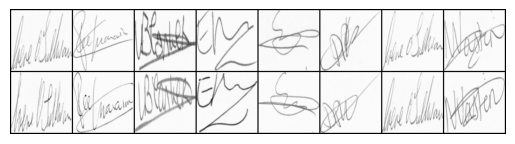

[[1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [12]:
# Viewing the sample of images and to check whether its loading properly
vis_dataloader = DataLoader(siamese_dataset, shuffle=True, batch_size=8)
dataiter = iter(vis_dataloader)

example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0], example_batch[1]), 0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

In [ ]:
# first_column_filenames = example_batch[3]  # These are the filenames for the first image in each pair
# print("First column image filenames:")
# for filename in first_column_filenames:
#     print(filename)

In [23]:
#create a siamese network
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        
        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            
            nn.Conv2d(1, 96, kernel_size=11,stride=1),
            nn.BatchNorm2d(96),
            #nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            
            nn.Conv2d(96, 256, kernel_size=5,stride=1,padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            #nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout(p=0.3),    ####### Use nn.Dropout in newer versions not Dropout2d

            nn.Conv2d(256,384 , kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384,256 , kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout(p=0.3),

        )
        
        # Defining the fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(30976, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            
            nn.Linear(1024, 128),
            nn.ReLU(inplace=True),
            
            nn.Linear(128,2))

    def forward_once(self, x):
        # Forward pass 
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # forward pass of input 1
        output1 = self.forward_once(input1)
        # forward pass of input 2
        output2 = self.forward_once(input2)
        return output1, output2

In [24]:
# Load the dataset as pytorch tensors using dataloader
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=0,  #.py file more workers (total=20)
                        batch_size=config.batch_size)

for i, data in enumerate(train_dataloader,0):
    print(i)
    if i> 5 : break

0
1
2
3
4
5
6


In [ ]:
def calculate_bal_accuracy(losses, labels, threshold=0.1):
    
    # Classify based on loss threshold (genuine (0) or fraud (1))
    predicted = (losses >= threshold).float()  # 1 if dissimilar (fraud), 0 if similar (genuine)
    
    # Initialize counters for TP, TN, FP, FN
    TP = ((predicted == 1) & (labels == 1)).sum().item()  # True Positive: Predicted fraud, actually fraud
    TN = ((predicted == 0) & (labels == 0)).sum().item()  # True Negative: Predicted genuine, actually genuine
    FP = ((predicted == 1) & (labels == 0)).sum().item()  # False Positive: Predicted fraud, actually genuine
    FN = ((predicted == 0) & (labels == 1)).sum().item()  # False Negative: Predicted genuine, actually fraud
    
    # Calculate sensitivity (True Positive Rate) and specificity (True Negative Rate)
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0  # Avoid division by zero
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0  # Avoid division by zero
    
    # Calculate balanced accuracy
    bal_accuracy = (sensitivity + specificity) / 2
    
    return TP, TN, FP, FN, bal_accuracy

cuda if GPU else CPU: cuda
Epoch 1
 Avg loss 0.2307700582731197
 Lerning Rate 0.001

Epoch 2
 Avg loss 0.07356356373236363
 Lerning Rate 0.001

Epoch 3
 Avg loss 0.07330827690537803
 Lerning Rate 0.001

Epoch 4
 Avg loss 0.07341822848934937
 Lerning Rate 0.001

Epoch 5
 Avg loss 0.07440349028109683
 Lerning Rate 0.001

Epoch 6
 Avg loss 0.07439689148863977
 Lerning Rate 0.001

Epoch 7
 Avg loss 0.07481635484546834
 Lerning Rate 0.001

Epoch 8
 Avg loss 0.07295155815636488
 Lerning Rate 0.001

Epoch 9
 Avg loss 0.07212866404537656
 Lerning Rate 0.001

Epoch 10
 Avg loss 0.07213387848198742
 Lerning Rate 0.001

Epoch 11
 Avg loss 0.07198111775533883
 Lerning Rate 0.001

Epoch 12
 Avg loss 0.07212888253416569
 Lerning Rate 0.001

Epoch 13
 Avg loss 0.0721038576143668
 Lerning Rate 0.001

Epoch 14
 Avg loss 0.0717909840133154
 Lerning Rate 0.001

Epoch 15
 Avg loss 0.07195812815764391
 Lerning Rate 0.001

Epoch 16
 Avg loss 0.07193023233723214
 Lerning Rate 0.001

Epoch 17
 Avg loss 0.0718

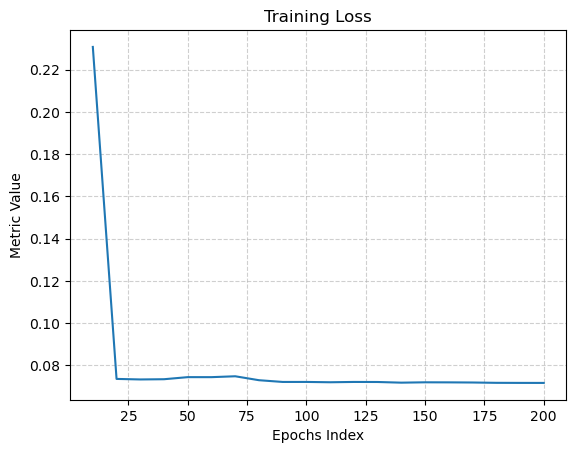

Model Saved Successfully


In [27]:
# Declare Siamese Network
net = SiameseNetwork().cuda()
# Decalre Loss Function
criterion = ContrastiveLoss()
# Declare Optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

#train the model
def train():
    checkpoint_data = {
        'loss': [],
        'counter': [],
        'bal_acc': [],
        'TP': [],
        'TN': [],
        'FP': [],
        'FN': [],}
    iteration_number = 0
    L_data = len(train_dataloader)

    for epoch in range(1, 21):  #config.epochs+1 20 epochs
        loss_sum = 0
        all_losses = []
        all_labels = []
        for i, data in enumerate(train_dataloader,0):  #726 instances
            img0, img1 , label = data
            img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
            optimizer.zero_grad()
            output1,output2 = net(img0,img1)
            loss_contrastive = criterion(output1,output2,label)
            loss_contrastive.backward()
            optimizer.step()
            torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)
            loss_sum += loss_contrastive.item()

            # Collect losses and labels for accuracy calculation
            all_losses.append(loss_contrastive.detach().view(-1))
            all_labels.append(label)

        iteration_number += 10
        avg_loss = loss_sum / L_data
        checkpoint_data['loss'].append(avg_loss)
        checkpoint_data['counter'].append(iteration_number)

        # Adjust learning rate
        scheduler.step(avg_loss)

        # Concatenate all losses and labels for the epoch
        all_losses = torch.cat(all_losses)
        all_labels = torch.cat(all_labels)

        TP, TN, FP, FN, bal_acc = calculate_bal_accuracy(all_losses, all_labels)
        checkpoint_data['bal_acc'].append(bal_acc)
        checkpoint_data['TP'].append(TP)
        checkpoint_data['TN'].append(TN)
        checkpoint_data['FP'].append(FP)
        checkpoint_data['FN'].append(FN)
        print("Epoch {}\n Avg loss {}\n Lerning Rate {}\n".format(epoch, avg_loss, optimizer.param_groups[0]['lr']))

    # show_plot(counter, loss)
    plt.plot(checkpoint_data['counter'], checkpoint_data['loss'], label='Contrastive Loss')
    # plt.plot(checkpoint_data['counter'], checkpoint_data['bal_acc'], label='Balanced Accuracy')
    plt.title('Training Loss')  #Balanced Accuracy
    plt.xlabel('Epochs Index')
    plt.ylabel('Metric Value')
    # plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()
    return net, checkpoint_data  # Return all

#set the device to cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu'); print(f"cuda if GPU else CPU: {device}")
model, summary = train()
torch.save(model.state_dict(), f"content/saved_model.pt")
torch.save(model, f"content/saved_model_full.pt")
print("Model Saved Successfully")

___

# Training outputs statistics

In [59]:
# see training model output
net = SiameseNetwork().cuda()
# Decalre Loss Function
criterion = ContrastiveLoss()
# Declare Optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

#train the model
threshold=0.1
checkpoint_data = {
    'loss': [],
    'counter': [],
    'bal_acc': [],
    'TP': [],
    'TN': [],
    'FP': [],
    'FN': [],
    'loss_forged' : [],
    'loss_original': [],}

iteration_number = 0
L_data = len(train_dataloader)

for epoch in range(1, 5):  # config.epochs + 1 for 20 epochs

    loss_sum = 0
    loss_forged_sum = 0  # Initialize forged loss sum
    loss_original_sum = 0  # Initialize original loss sum
    forged_count = 0  # Counter for forged pairs
    original_count = 0  # Counter for original pairs

    all_predictions = []
    all_labels = []
    
    for i, data in enumerate(train_dataloader, 0):  # 726 instances
        img0, img1, label = data
        img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
        optimizer.zero_grad()
        output1, output2 = net(img0, img1)
        
        loss_contrastive = criterion(output1, output2, label)
        loss_contrastive.backward()
        optimizer.step()
        torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)
        loss_sum += loss_contrastive.item()

        # Separate losses for forged and original pairs
        for j in range(label.size(0)):  # Loop through each sample in the batch
            if label[j].item() == 1:  # Forged pair
                loss_forged_sum += criterion(output1[j:j+1], output2[j:j+1], label[j:j+1]).item()
                forged_count += 1
            else:  # Original pair
                loss_original_sum += criterion(output1[j:j+1], output2[j:j+1], label[j:j+1]).item()
                original_count += 1
    
    iteration_number += 10
    avg_loss = loss_sum / L_data
    avg_loss_forged = loss_forged_sum / forged_count if forged_count > 0 else 0  # Average loss for forged pairs
    avg_loss_original = loss_original_sum / original_count if original_count > 0 else 0  # Average loss for original pairs

    checkpoint_data['loss'].append(avg_loss)
    checkpoint_data['counter'].append(iteration_number)
    # checkpoint_data['bal_acc'].append(balanced_acc)
    checkpoint_data['loss_forged'].append(avg_loss_forged)
    checkpoint_data['loss_original'].append(avg_loss_original)

    # Adjust learning rate
    scheduler.step(avg_loss)

    # Epoch Summary
    print(f"Epoch {epoch} Summary:")
    print(f"Average Loss: {avg_loss:.4f}")
    # print(f"Balanced Accuracy: {balanced_acc:.2f}")
    print(f"Average Loss for Forged Pairs: {avg_loss_forged:.4f}")
    print(f"Average Loss for Original Pairs: {avg_loss_original:.4f}")

# checkpoint_data['bal_acc']

Epoch 1 Summary:
Average Loss: 0.2856
Average Loss for Forged Pairs: 0.0984
Average Loss for Original Pairs: 0.4543
Epoch 2 Summary:
Average Loss: 0.0732
Average Loss for Forged Pairs: 0.1088
Average Loss for Original Pairs: 0.0438
Epoch 3 Summary:
Average Loss: 0.0733
Average Loss for Forged Pairs: 0.1077
Average Loss for Original Pairs: 0.0439
Epoch 4 Summary:
Average Loss: 0.0735
Average Loss for Forged Pairs: 0.1087
Average Loss for Original Pairs: 0.0441


In [51]:
checkpoint_data['bal_acc']

[0.49858457635884523,
 0.5,
 0.5010865632393643,
 0.4999460181585245,
 0.5006406798146665]

___

# Inference

In [28]:
import json

# Assuming summary is a dictionary or serializable object
with open('model_summary.json', 'w') as f:
    json.dump(summary, f, indent=4)

In [ ]:
# # Declare Siamese Network
# net = SiameseNetwork().cuda()
# # Decalre Loss Function
# criterion = ContrastiveLoss()
# # Declare Optimizer
# optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, weight_decay=0.0005)

# #train the model
# def train(train_dataloader):
#     loss=[] 
#     counter=[]
#     iteration_number = 0
#     for i, data in enumerate(train_dataloader,0):
#       img0, img1 , label = data
#       img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
#       optimizer.zero_grad()
#       output1,output2 = net(img0,img1)
#       loss_contrastive = criterion(output1,output2,label)
#       loss_contrastive.backward()
#       optimizer.step()
#       loss.append(loss_contrastive.item())
#     loss = np.array(loss)
#     return loss.mean()/len(train_dataloader)


# def eval(eval_dataloader):
#     loss=[] 
#     counter=[]
#     iteration_number = 0
#     for i, data in enumerate(eval_dataloader,0):
#       img0, img1 , label = data
#       img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
#       output1,output2 = net(img0,img1)
#       loss_contrastive = criterion(output1,output2,label)
#       loss.append(loss_contrastive.item())
#     loss = np.array(loss)
#     return loss.mean()/len(eval_dataloader)




# best_eval_loss = 9999

# for epoch in range(1, config.epochs):
#   train_loss = train(train_dataloader)
#   eval_loss = eval(eval_dataloader)

#   print(f"Training loss{train_loss}")
#   print("-"*20)
#   print(f"Eval loss{eval_loss}")

#   if eval_loss<best_eval_loss:
#     best_eval_loss = eval_loss
#     print("-"*20)
#     print(f"Best Eval loss{best_eval_loss}")
#     torch.save(net.state_dict(), "/content/model.pth")
#     print("Model Saved Successfully")

#     # 2358 min more

In [ ]:
# torch.save(model.state_dict(), f"content/saved_model.pt")
# torch.save(model, f"content/saved_model.pt")

In [6]:
model = torch.load("content/saved_model_full.pt")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu'); print(f"cuda if GPU else CPU: {device}")
model.to(device)
model.eval()

# Load the test dataset
test_dataset = SiameseDataset(
    testing_csv,
    testing_dir,
    transform=transforms.Compose(
        [transforms.Resize((105, 105)), transforms.ToTensor()]
    ),
)

test_dataloader = DataLoader(test_dataset, num_workers=0, batch_size=1, shuffle=True)  #num_workers=8

C:\Users\diagl.DIAGLC-DEV-02\AppData\Local\Temp\ipykernel_12240\1665563184.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("content/saved_model_full.p

cuda if GPU else CPU: cuda


Pairs Of Signatures


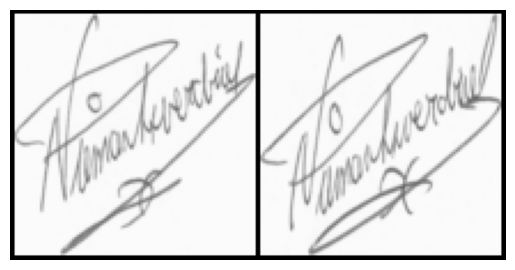

Predicted Eucledian Distance: 0.0034
Contrastive Loss: 0.0000
Actual Label: Original
Predicted: Original
-------------------------------------------------------------------


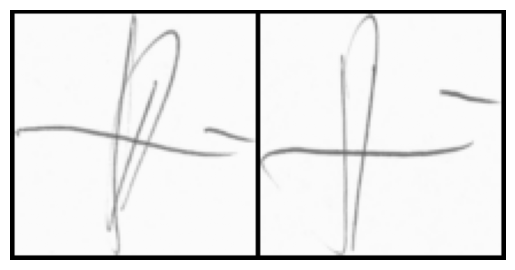

Predicted Eucledian Distance: 0.0049
Contrastive Loss: 0.0000
Actual Label: Original
Predicted: Original
-------------------------------------------------------------------


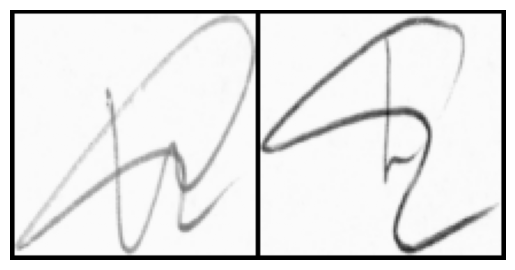

Predicted Eucledian Distance: 0.023
Contrastive Loss: 0.2275
Actual Label: Forged
Predicted: Forged
-------------------------------------------------------------------


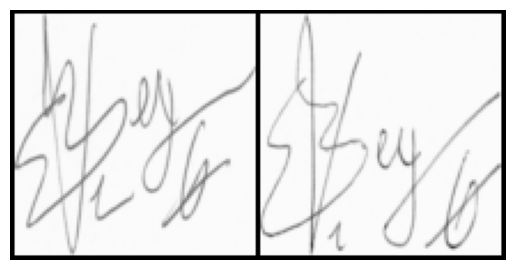

Predicted Eucledian Distance: 0.0114
Contrastive Loss: 0.2387
Actual Label: Forged
Predicted: Forged
-------------------------------------------------------------------


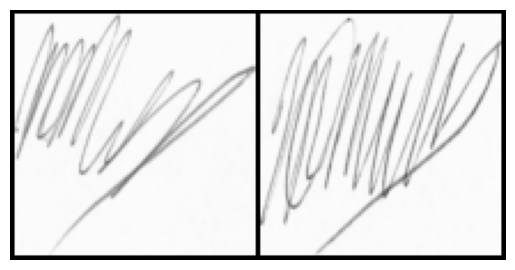

Predicted Eucledian Distance: 0.0184
Contrastive Loss: 0.2320
Actual Label: Forged
Predicted: Forged
-------------------------------------------------------------------


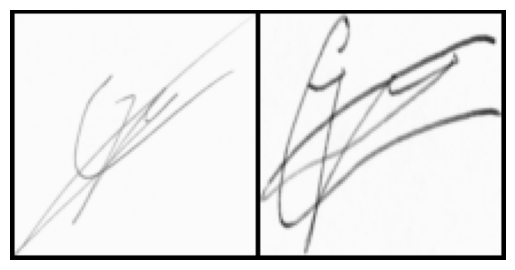

Predicted Eucledian Distance: 0.0686
Contrastive Loss: 0.1861
Actual Label: Forged
Predicted: Forged
-------------------------------------------------------------------


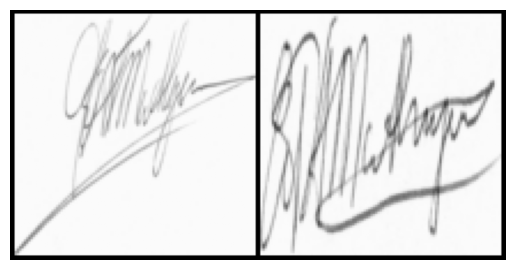

Predicted Eucledian Distance: 0.0198
Contrastive Loss: 0.2306
Actual Label: Forged
Predicted: Forged
-------------------------------------------------------------------


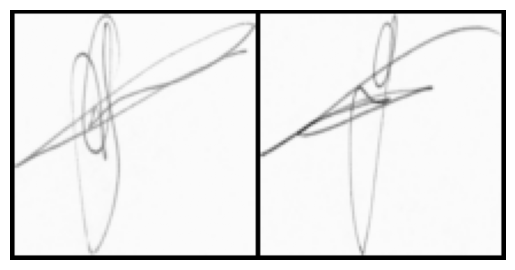

Predicted Eucledian Distance: 0.0081
Contrastive Loss: 0.2420
Actual Label: Forged
Predicted: Forged
-------------------------------------------------------------------


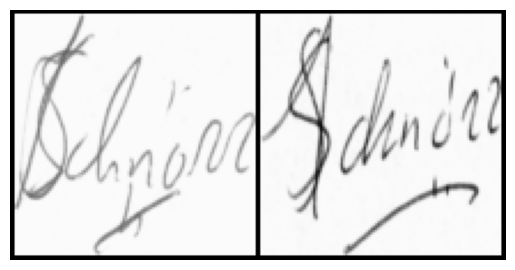

Predicted Eucledian Distance: 0.0106
Contrastive Loss: 0.2395
Actual Label: Forged
Predicted: Forged
-------------------------------------------------------------------


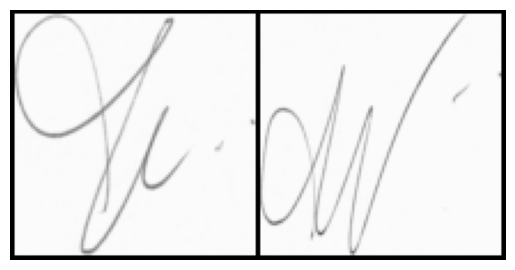

Predicted Eucledian Distance: 0.009
Contrastive Loss: 0.2411
Actual Label: Forged
Predicted: Forged
-------------------------------------------------------------------


In [7]:
threshold = 0.1  # Adjust
contrastive_loss_fn = ContrastiveLoss()

print("Pairs Of Signatures")

count = 0
for i, data in enumerate(test_dataloader, 0):
    x0, x1, label = data
    concat = torch.cat((x0, x1), 0)
    output1,output2 = model(x0.to(device),x1.to(device))

    eucledian_distance = F.pairwise_distance(output1, output2)

    if label.item() == 0:  #label == torch.FloatTensor([[0]]):
        label_text = "Original"
    else:
        label_text = "Forged"

    # Calculate contrastive loss for the pair
    label_tensor = label.to(device).float().view(-1)  # Ensure correct shape and type
    loss = contrastive_loss_fn(output1, output2, label_tensor)

    # Predict based on threshold
    prediction = "Forged" if loss > threshold else "Original"

    imshow(torchvision.utils.make_grid(concat))
    print("Predicted Eucledian Distance:", round(eucledian_distance.item(), 4))
    print(f"Contrastive Loss: {loss.item():.4f}")
    print("Actual Label:", label_text)
    print(f"Predicted: {prediction}")
    print("-" * 67)
    count = count + 1
    if count == 10:
        break

# Performance Metrics for testing dataset

In [ ]:
# from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

# Initialize lists to store predictions and labels
all_predictions = []
all_labels = []

threshold = 0.17  # Adjust threshold
contrastive_loss_fn = ContrastiveLoss()

print("Pairs Of Signatures")

L_data_test = len(test_dataloader)
count = 0

for i, data in enumerate(test_dataloader, 0):
    x0, x1, label = data
    concat = torch.cat((x0, x1), 0)
    output1, output2 = model(x0.to(device), x1.to(device))

    # Calculate contrastive loss for the pair
    label_tensor = label.to(device).float().view(-1)  # Ensure correct shape and type
    loss = contrastive_loss_fn(output1, output2, label_tensor)

    # Predict based on threshold
    prediction = (loss > threshold).float()  # 1 for "Forged", 0 for "Original"
    
    # Store predictions and labels for metrics calculation
    all_predictions.append(prediction.item())
    all_labels.append(label.item())

    # Visualize and print individual results
    if label.item() == 0:
        label_text = "Original"
    else:
        label_text = "Forged"


# Calculate performance metrics
all_predictions = torch.tensor(all_predictions)
all_labels = torch.tensor(all_labels)

# Accuracy
accuracy = accuracy_score(all_labels, all_predictions)

# Balanced Accuracy
balanced_acc = balanced_accuracy_score(all_labels, all_predictions)

# Precision
precision = precision_score(all_labels, all_predictions, pos_label=1)

# Recall (Sensitivity)
recall = recall_score(all_labels, all_predictions, pos_label=1)

# Specificity (True Negative Rate)
tn, fp, fn, tp = confusion_matrix(all_labels, all_predictions).ravel()
specificity = tn / (tn + fp)

# F1 Score
f1 = f1_score(all_labels, all_predictions, pos_label=1)

# Print metrics
print(f"\nPerformance Metrics on Test Data ({L_data_test} images, Contrastive Loss threshold for classification = {threshold}):\n")
print(f"Accuracy: {accuracy:.2f}")
print(f"Balanced Accuracy: {balanced_acc:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall (Sensitivity): {recall:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"TN: {tn:.2f} | FP: {fp:.2f} | FN: {fn:.2f} | TP: {tp:.2f}")

Pairs Of Signatures

Performance Metrics on Test Data (5747 images, Contrastive Loss threshold for classification = 0.17):

Accuracy: 1.00
Balanced Accuracy: 1.00
Precision: 1.00
Recall (Sensitivity): 1.00
Specificity: 1.00
F1 Score: 1.00
TN: 2772.00 | FP: 0.00 | FN: 1.00 | TP: 2974.00


# Statistics for Loss during testing

In [8]:
criterion = ContrastiveLoss()

# Initialize lists to store distances and labels
distances = []
labels = []
losses = []

# Loop through the test data
count = 0
for i, data in enumerate(test_dataloader, 0):
    x0, x1, label = data
    concat = torch.cat((x0, x1), 0)
    output1, output2 = model(x0.to(device), x1.to(device))

    # Calculate Euclidean distance
    eucledian_distance = F.pairwise_distance(output1, output2).item()
    loss = criterion(output1, output2, label.to(device)).item()

    # Append distance and label to lists
    distances.append(eucledian_distance)
    labels.append("Genuine" if label.item() == 0 else "Forged")   #labels.append("Genuine" if label == torch.FloatTensor([[0]]) else "Forged")
    losses.append(loss)

    count += 1
#-------------------------------------------------------------------------------------
# Create a DataFrame for analysis
results_df = pd.DataFrame({
    "Distance": distances,
    "Loss": losses,
    "Label": labels
})

# Calculate statistics for genuine and forged pairs
genuine_stats = results_df[results_df["Label"] == "Genuine"][["Distance", "Loss"]].describe()
forged_stats = results_df[results_df["Label"] == "Forged"][["Distance", "Loss"]].describe()

# Print statistics
print("Genuine Pair Statistics:\n", genuine_stats)
print("\nForged Pair Statistics:\n", forged_stats)

Genuine Pair Statistics:
           Distance          Loss
count  2772.000000  2.772000e+03
mean      0.010504  1.898269e-04
std       0.008918  4.167822e-04
min       0.000165  2.723674e-08
25%       0.004621  2.134994e-05
50%       0.008052  6.484265e-05
75%       0.013386  1.791916e-04
max       0.080955  6.553703e-03

Forged Pair Statistics:
           Distance         Loss
count  2975.000000  2975.000000
mean      0.018179     0.232360
std       0.014449     0.013590
min       0.000274     0.165305
25%       0.007923     0.226412
50%       0.014017     0.236180
75%       0.024172     0.242139
max       0.093422     0.249727
